<a href="https://colab.research.google.com/github/Tommy-Ngx/ColabRerun/blob/main/Segmentation/seg_icevision_openimages.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Train Custom Image Segmentation Model with `IceVision` and `OpenImages`
Source: www.machinelearne.ar

## Install and load dependencies

Run the following lines and restart your kernel after you are finished.

In [ ]:
!git clone -b issue_7_segmentation_support https://github.com/monocongo/openimages.git oid
!pip install -r oid/requirements.txt

Now install `icevision` and `imantics`.

In [ ]:
!pip install icevision[all]
!pip install imantics

Add your `icevision` path to `PYTHON_PATH` in order to load the library.

In [4]:
import sys
sys.path.append('oid/src')

In [5]:
from openimages.download import download_segmentation_dataset

## Download annotations from `OpenImages`
Source: https://storage.googleapis.com/openimages/web/index.html

> Open Images is a dataset of ~9M images annotated with image-level labels, object bounding boxes, object segmentation masks, visual relationships, and localized narratives:
>
> It contains a total of 16M bounding boxes for 600 object classes on 1.9M images, making it the largest existing dataset with object location annotations. The boxes have been largely manually drawn by professional annotators to ensure accuracy and consistency. The images are very diverse and often contain complex scenes with several objects (8.3 per image on average).
Open Images also offers visual relationship annotations, indicating pairs of objects in particular relations (e.g. "woman playing guitar", "beer on table"), object properties (e.g. "table is wooden"), and human actions (e.g. "woman is jumping"). In total it has 3.3M annotations from 1,466 distinct relationship triplets.
In V5 we added segmentation masks for 2.8M object instances in 350 classes. Segmentation masks mark the outline of objects, which characterizes their spatial extent to a much higher level of detail.
In V6 we added 675k localized narratives: multimodal descriptions of images consisting of synchronized voice, text, and mouse traces over the objects being described. (Note we originally launched localized narratives only on train in V6, but since July 2020 we also have validation and test covered.)
Finally, the dataset is annotated with 59.9M image-level labels spanning 19,957 classes.

In [7]:
!rm -rf /content/sample_data

In [6]:
download_segmentation_dataset(dest_dir="anno", 
                              class_labels=["Hot dog",], 
                              annotation_format="pascal",
                              meta_dir="csv_anno")

GET class-descriptions-boxable.csv: 100%|██████████| 12.0k/12.0k [00:00<00:00, 3.73MiB/s]
2022-04-21  07:15:14 INFO Reading bounding box data
GET train-annotations-bbox.csv: 100%|██████████| 1.19G/1.19G [00:05<00:00, 203MiB/s]
2022-04-21  07:15:43 INFO Reading segmentation mask data
GET train-annotations-object-segmentation.csv: 100%|██████████| 807M/807M [00:05<00:00, 152MiB/s]
2022-04-21  07:16:03 INFO Downloading 43 train images and accompanying segmentation masks for class 'hot dog'
GET train-masks-0.zip: 100%|██████████| 386M/386M [00:03<00:00, 117MiB/s]
GET train-masks-1.zip: 100%|██████████| 298M/298M [00:01<00:00, 224MiB/s]
GET train-masks-2.zip: 100%|██████████| 285M/285M [00:02<00:00, 135MiB/s] 
GET train-masks-3.zip: 100%|██████████| 282M/282M [00:01<00:00, 224MiB/s]
GET train-masks-4.zip: 100%|██████████| 278M/278M [00:04<00:00, 67.4MiB/s]
GET train-masks-5.zip: 100%|██████████| 274M/274M [00:01<00:00, 196MiB/s]
GET train-masks-6.zip: 100%|██████████| 277M/277M [00:01<00:00

{'hot dog': {'annotations_dir': 'anno/hot dog/pascal',
  'images_dir': 'anno/hot dog/images',
  'segmentations_dir': 'anno/hot dog/segmentations'}}

## Create COCO Segmentation Dataset and COCO `annotation.json`

In [8]:
import imantics
from PIL import Image
from icevision.all import *

2022-04-21  07:17:43 INFO NumExpr defaulting to 2 threads.
INFO     - Downloading default `.ttf` font file - SpaceGrotesk-Medium.ttf from https://raw.githubusercontent.com/airctic/storage/master/SpaceGrotesk-Medium.ttf to /root/.icevision/fonts/SpaceGrotesk-Medium.ttf | icevision.visualize.utils:get_default_font:70


In [9]:
data_dir = Path('anno/hot dog')

images_dir = data_dir / 'images'
annotations_dir = data_dir / 'pascal'
segmentations_dir = data_dir / 'segmentations'

In [33]:
%cd /content/tommy
data_dir = Path('/content/tommy/')

images_dir = data_dir / 'val'
annotations_dir = data_dir / 'pascal'
segmentations_dir = data_dir / 'valmask'

/content/tommy


In [34]:
list_of_images = [x for x in images_dir.rglob('*.jpg')]
list_of_segmentations = [x for x in segmentations_dir.rglob('*.png')]

Use the following custom function to generate `annotations.json` from your images + segmentation masks. Follow this article to get a better understanding of how `COCO` is structured: https://www.immersivelimit.com/tutorials/create-coco-annotations-from-scratch/#coco-dataset-format

In [11]:
def create_coco_annotation_json(
    list_of_images: List[Path], 
    list_of_segmentations: List[Path],
    class_map: str = 'hot dog',
    path_to_output_json: str = 'annotation.json') -> Dict:
    """
    Source: www.machinelearne.ar
    Generates a COCO annotated json that maps images with segmentation masks
    :param images_dir: list of images 
    :param segmentations_dir: list of segmentations masks
    :param path_to_output_json: map images with segmentations into json
    """
    from datetime import date
    import json

    # create coco dict
    coco_segm_dict = defaultdict(list, { str(k):[] for k in list_of_images })
    for img in list_of_images:
      for mask in list_of_segmentations:
        if img.stem in str(mask): coco_segm_dict[str(img)].append(str(mask))

    # create base json
    coco = {
        "info": {
            "description": "Custom COCO Dataset",
            "url": "http://cocodataset.org",
            "version": "1.0",
            "year": 2020,
            "contributor": "www.machinelearne.ar",
            "date_created": date.today().strftime("%d/%m/%Y")},
        "images": [],
        "annotations": [],
        "categories": [],
        }

    # merge images with segmentations and create json
    annotations=[]
    images=[]
    segm_id = 0
    for id, (img,masks) in enumerate(list(coco_segm_dict.items())):
      image = imantics.Image.from_path(img)
      for x in masks:
        array = np.asarray(Image.open(x).resize(image.size))
        image.add(imantics.Mask(array), category=imantics.Category(class_map))
        image.id = id
        coco_json = image.export(style='coco')
        annotation = coco_json['annotations'][0]
        annotation['id'] = segm_id
        annotations.append(coco_json['annotations'][0])
        segm_id += 1
      images.append(coco_json['images'][0])
    # add to json and save to disk
    coco['categories'] = coco_json['categories']
    coco['annotations'] = annotations
    coco['images'] = images

    with open(path_to_output_json, 'w') as f:
        json.dump(coco, f)

    print(f"Done! File was saved to '{Path.cwd()}/{(path_to_output_json)}'")
    return coco

In [32]:
coco_json = create_coco_annotation_json(list_of_images, list_of_segmentations)

Done! File was saved to '/content/tommy/annotation.json'


In [18]:
os.environ['KAGGLE_USERNAME'] = "ccc" # username from the json file
os.environ['KAGGLE_KEY'] = "ggg" # key from the json file
#!kaggle datasets create -p /content/tommyKaggle
!kaggle datasets download -d tommyngx/unimib2016pre5

100% 2.74G/2.74G [00:11<00:00, 222MB/s]
100% 2.74G/2.74G [00:11<00:00, 248MB/s]


In [19]:
import os
os.makedirs("/content/tommy",exist_ok=True)

In [ ]:
!unzip /content/unimib2016pre5.zip -d /content/tommy

## Parse and load data, preview

In [35]:
class_map = ClassMap(['Food'])

In [36]:
parser = parsers.COCOMaskParser(
    annotations_filepath='/content/tommy/annotationval.json', img_dir=images_dir)

In [37]:
train_records, valid_records = parser.parse()

INFO     - Autofixing records | icevision.parsers.parser:parse:122


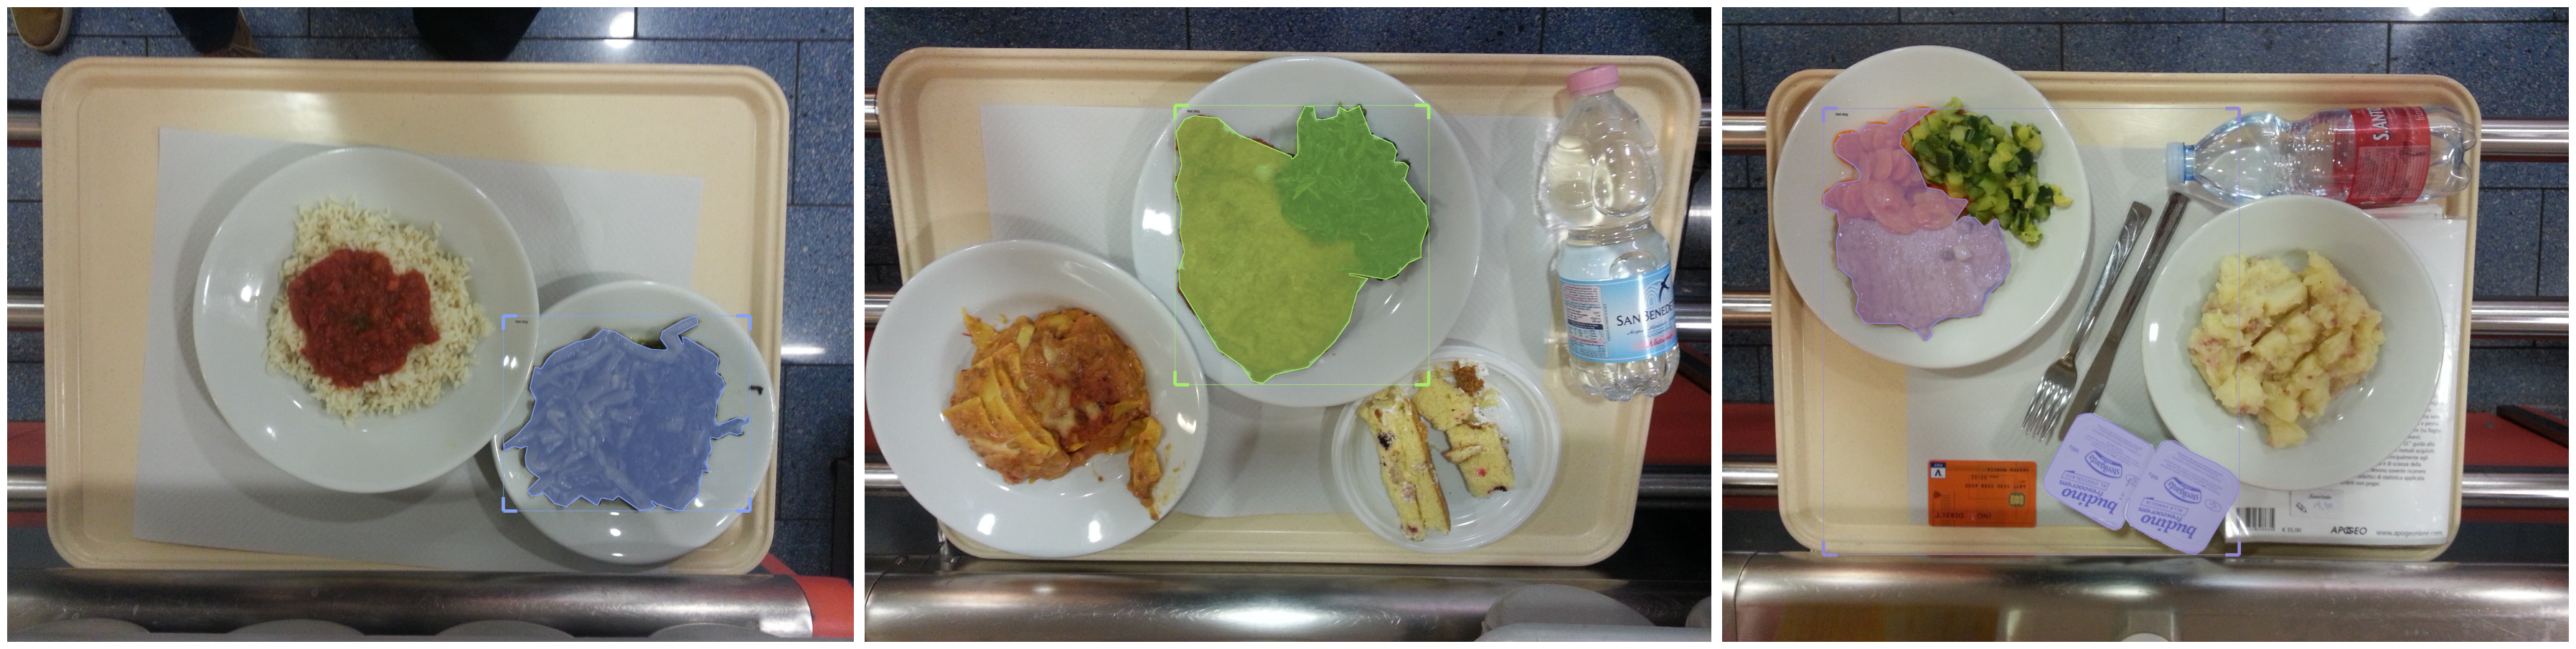

In [39]:
show_records(train_records[:3], ncols=3, class_map=class_map)

## (`Optional`) Train with PyTorch Lighting

In [ ]:
# train_records, valid_records = parser.parse()

# # Define the transforms and create the Datasets
# presize = 512
# size = 384
# shift_scale_rotate = tfms.A.ShiftScaleRotate(rotate_limit=10)
# crop_fn = partial(tfms.A.RandomSizedCrop, min_max_height=(size // 2, size), p=0.5)
# train_tfms = tfms.A.Adapter(
#     [
#         *tfms.A.aug_tfms(
#             size=size,
#             presize=presize,
#             shift_scale_rotate=shift_scale_rotate,
#             crop_fn=crop_fn,
#         ),
#         tfms.A.Normalize(),
#     ]
# )
# valid_tfms = tfms.A.Adapter([*tfms.A.resize_and_pad(size=size), tfms.A.Normalize()])
# train_ds = Dataset(train_records, train_tfms)
# valid_ds = Dataset(valid_records, valid_tfms)

# # Shows how the transforms affects a single sample
# samples = [train_ds[0] for _ in range(6)]
# show_samples(
#     samples, denormalize_fn=denormalize_imagenet, ncols=3, display_label=False, show=True
# )

# # Create DataLoaders
# train_dl = mask_rcnn.train_dl(train_ds, batch_size=16, shuffle=True, num_workers=4)
# valid_dl = mask_rcnn.valid_dl(valid_ds, batch_size=16, shuffle=False, num_workers=4)

# # Define metrics for the model
# # TODO: Currently broken for Mask RCNN
# # metrics = [COCOMetric(COCOMetricType.mask)]

# # Create model
# model = mask_rcnn.model(num_classes=len(class_map))

# # Train using pytorch-lightning
# class LightModel(faster_rcnn.lightning.ModelAdapter):
#     def configure_optimizers(self):
#         return SGD(self.parameters(), lr=1e-4)

# light_model = LightModel(model, metrics=metrics)

# trainer = pl.Trainer(max_epochs=10, gpus=1)
# trainer.fit(light_model, train_dl, valid_dl)

# # BONUS: Use model for inference. In this case, let's take some images from valid_ds
# # Take a look at `Dataset.from_images` if you want to predict from images in memory
# samples = [valid_ds[i] for i in range(6)]
# batch, samples = mask_rcnn.build_infer_batch(samples)
# preds = mask_rcnn.predict(model=model, batch=batch)

# imgs = [sample["img"] for sample in samples]
# show_preds(samples=imgs, preds=preds, denormalize_fn=denormalize_imagenet, ncols=3)

## Train with `FastAI`

In [ ]:
!pip install icedata
!pip install icevision[all] icedata

In [55]:
from icevision.all import *
import icedata

INFO     - Autofixing records | icevision.parsers.parser:parse:122


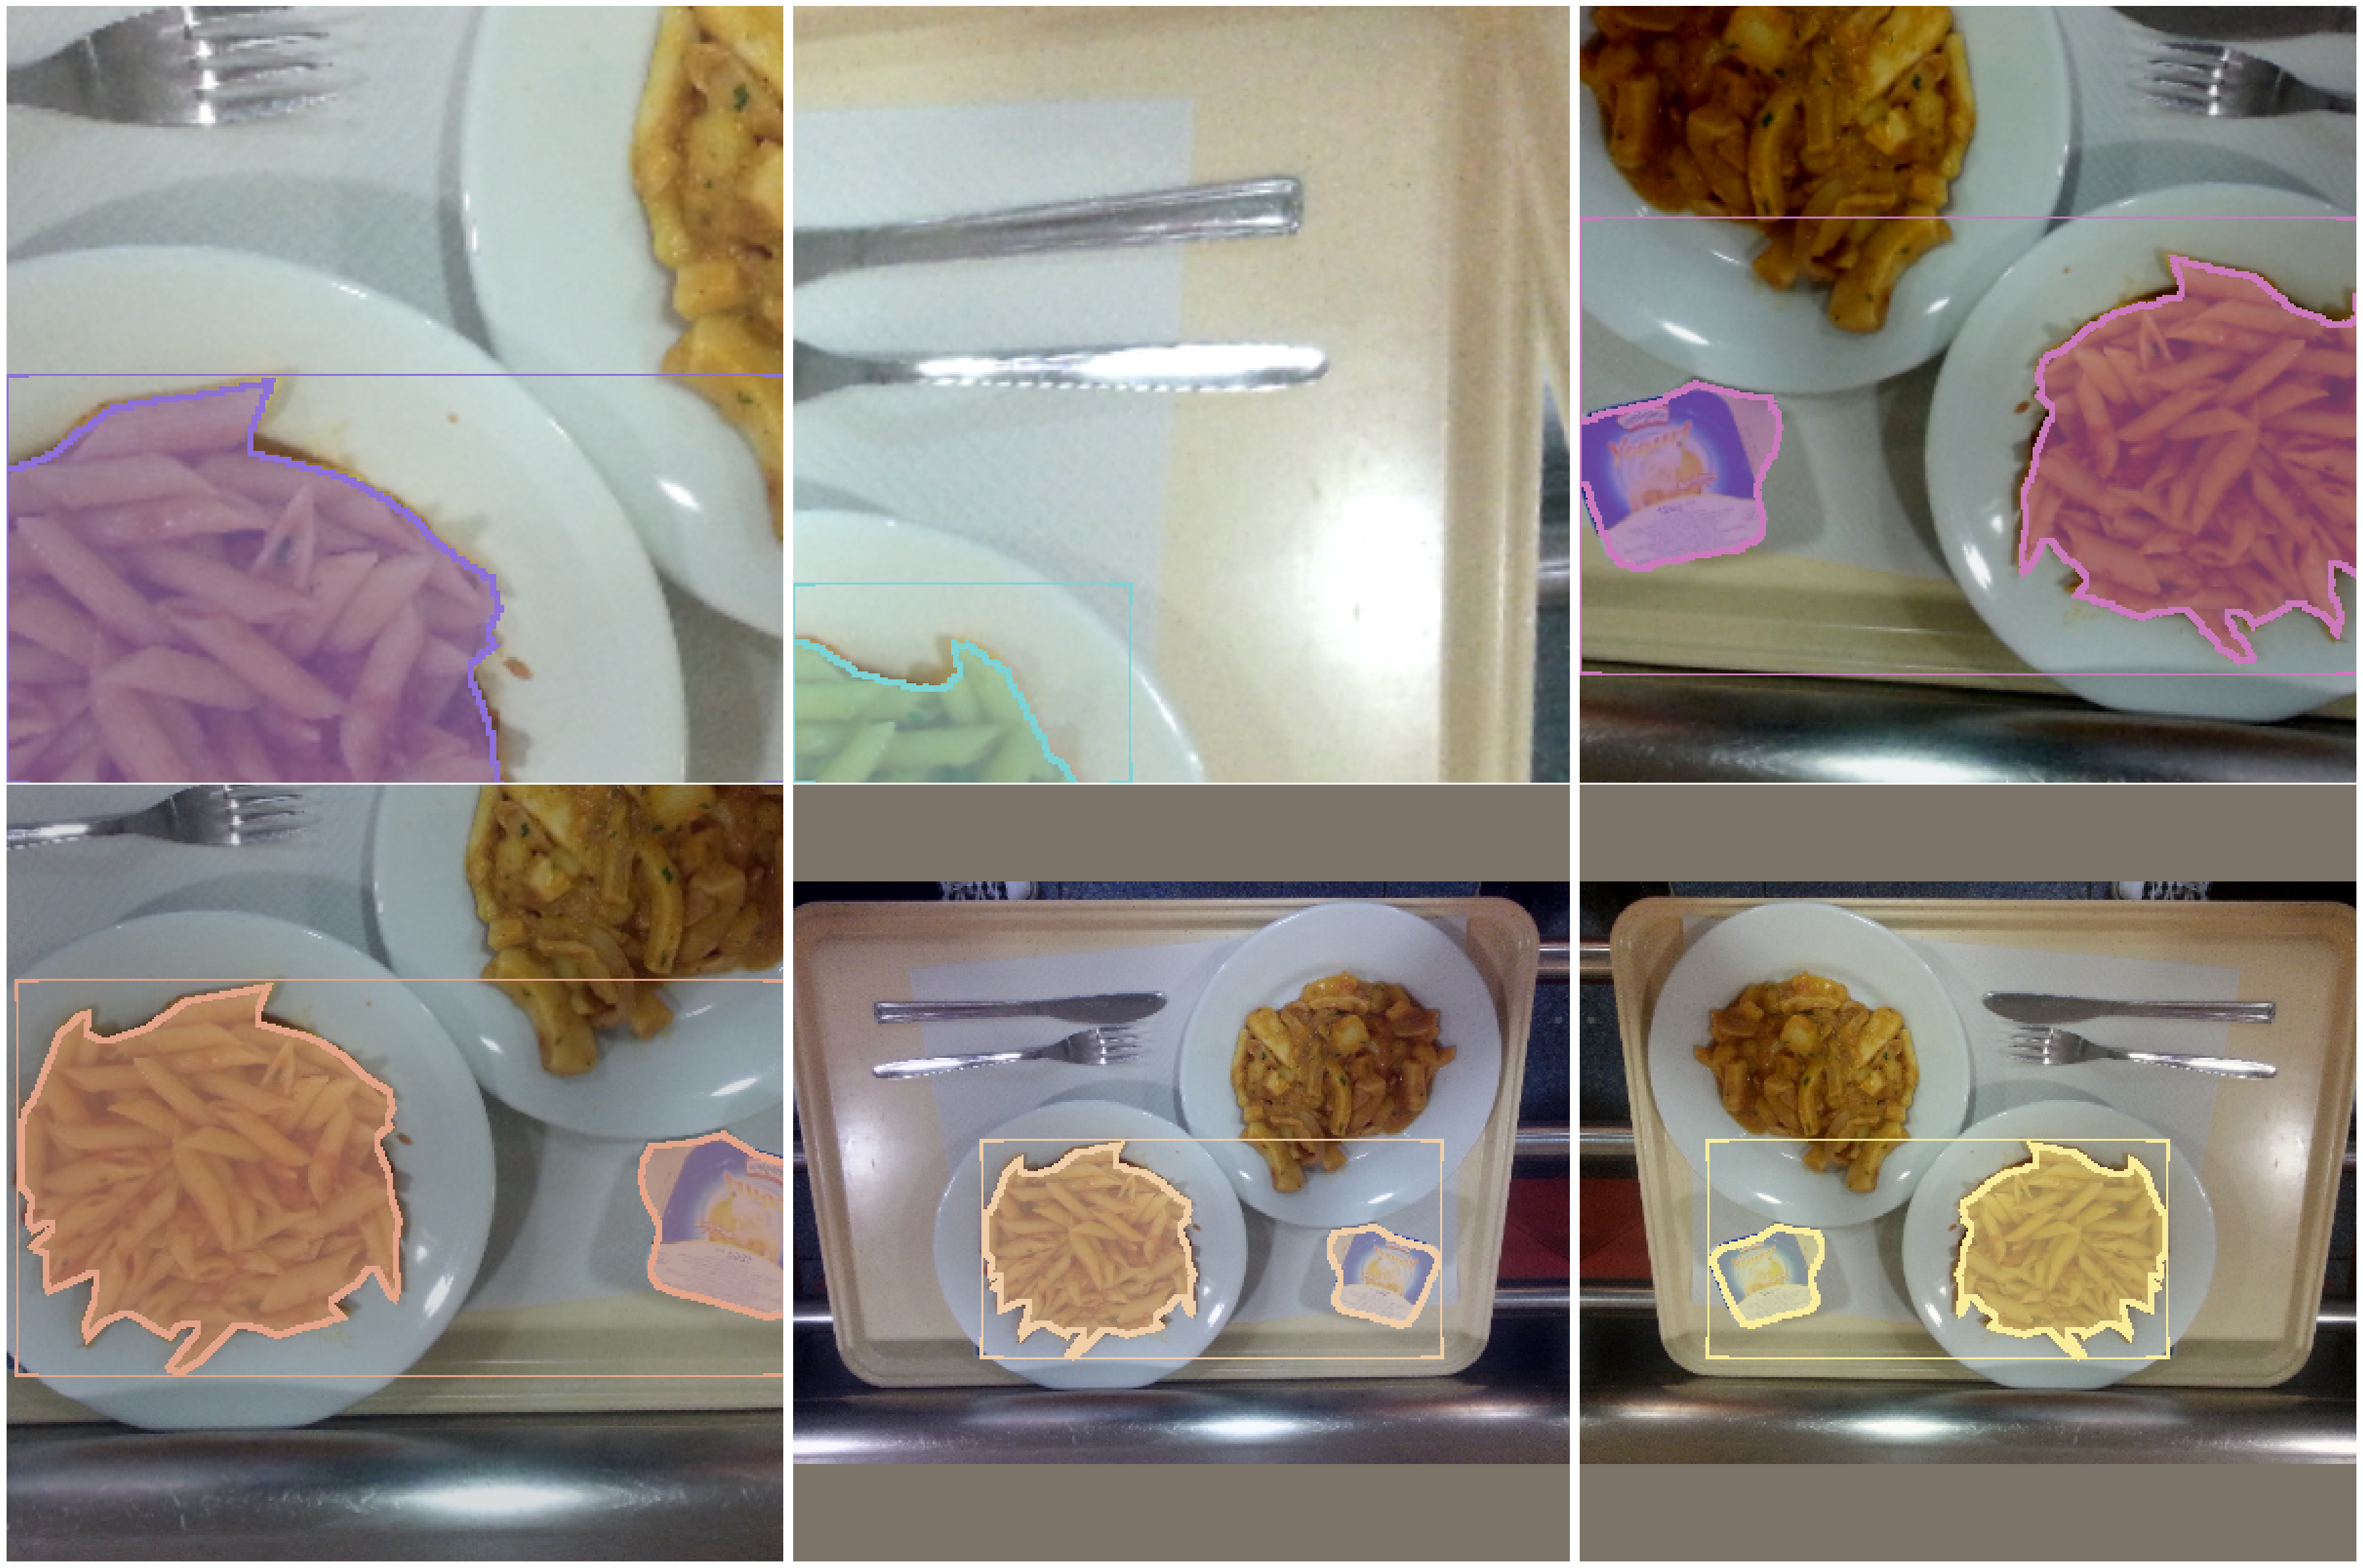

<module 'icevision.core.class_map' from '/usr/local/lib/python3.7/dist-packages/icevision/core/class_map.py'>


In [64]:
# Parse records with random splits
train_records, valid_records = parser.parse()

# Define the transforms and create the Datasets
presize = 512
size = 384
shift_scale_rotate = tfms.A.ShiftScaleRotate(rotate_limit=10)
crop_fn = partial(tfms.A.RandomSizedCrop, min_max_height=(size // 2, size), p=0.5)
train_tfms = tfms.A.Adapter(
    [
        *tfms.A.aug_tfms(
            size=size,
            presize=presize,
            shift_scale_rotate=shift_scale_rotate,
            crop_fn=crop_fn,
        ),
        tfms.A.Normalize(),
    ]
)
valid_tfms = tfms.A.Adapter([*tfms.A.resize_and_pad(size=size), tfms.A.Normalize()])
train_ds = Dataset(train_records, train_tfms)
valid_ds = Dataset(valid_records, valid_tfms)

# Shows how the transforms affects a single sample
samples = [train_ds[0] for _ in range(6)]
show_samples(
    samples, denormalize_fn=denormalize_imagenet, ncols=3, display_label=False, show=True
)

mask_rcnn = models.torchvision.mask_rcnn
# Create DataLoaders
train_dl = mask_rcnn.train_dl(train_ds, batch_size=16, shuffle=True, num_workers=4)
valid_dl = mask_rcnn.valid_dl(valid_ds, batch_size=16, shuffle=False, num_workers=4)

# Define metrics for the model
# TODO: Currently broken for Mask RCNN
# metrics = [COCOMetric(COCOMetricType.mask)]

print(class_map)
# Create model
model = mask_rcnn.model(num_classes=1)#len(class_map))



In [ ]:
# Create Fastai Learner and train the model
learn = mask_rcnn.fastai.learner(dls=[train_dl, valid_dl], model=model)
learn.fine_tune(10, 5e-4, freeze_epochs=1)

# BONUS: Use model for inference. In this case, let's take some images from valid_ds
# Take a look at `Dataset.from_images` if you want to predict from images in memory
samples = [valid_ds[i] for i in range(6)]
batch, samples = mask_rcnn.build_infer_batch(samples)
preds = mask_rcnn.predict(model=model, batch=batch)

imgs = [sample["img"] for sample in samples]
show_preds(samples=imgs, preds=preds, denormalize_fn=denormalize_imagenet, ncols=3, class_map=class_map)

In [ ]:

#zip -r SOF.zip val valmask valmask2 train trainmask trainmask2 test testmask testmask2 trayseg.pth.pth annotationtest.json annotationval.json annotationtrain.json

## Save model to `Google Drive`

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)
root_dir = Path('/content/gdrive/MyDrive/')

Mounted at /content/gdrive


In [ ]:
fname = root_dir/'icevision/models/chori/chori_maskrcnn.pth'
fname.parent.mkdir(parents=True, exist_ok=True)

In [ ]:
torch.save(model.state_dict(), fname)

## Run inference on a single image with `FastAI`

In [ ]:
import PIL, requests
def image_from_url(url):
    res = requests.get(url, stream=True)
    img = PIL.Image.open(res.raw)
    return np.array(img)

In [ ]:
image_url = "https://s32020.pcdn.co/wp-content/uploads/2020/06/Choripan-e1593021143177.jpeg.optimal.jpeg"
# image_url = 'https://www.babeldigital.com.ar/data/img_cont/img_imagenes/img_gr/7547.jpg'
img = image_from_url(image_url)
show_img(img);

In [ ]:
infer_tfms = tfms.A.Adapter([*tfms.A.resize_and_pad(size=384), tfms.A.Normalize()])
infer_ds = Dataset.from_images([img], infer_tfms)

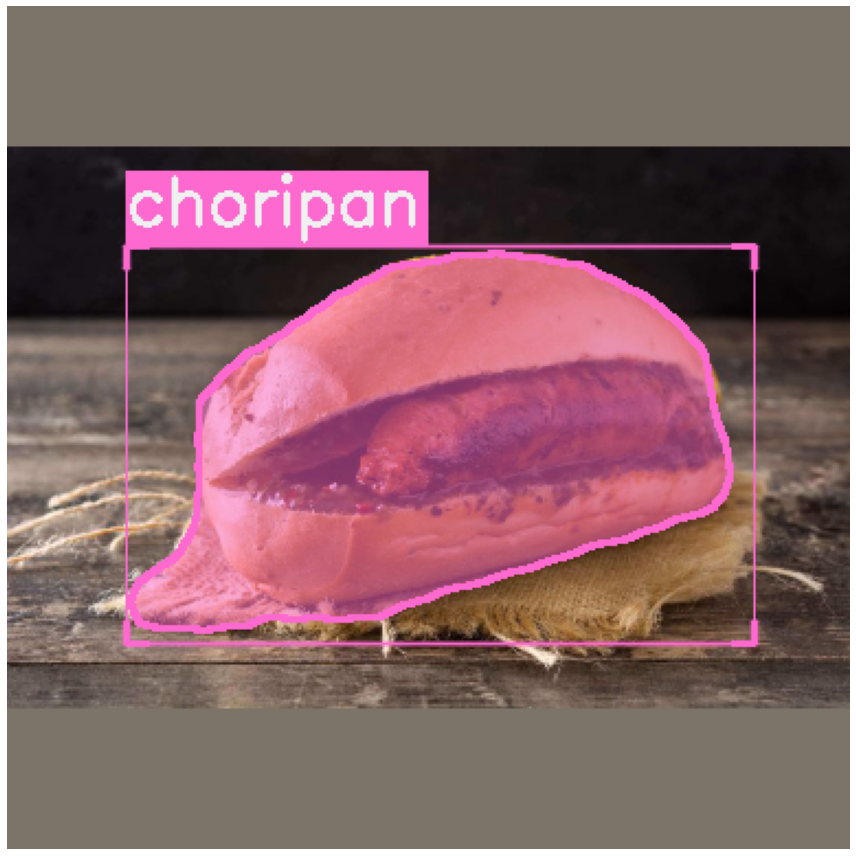

In [ ]:
batch, samples = mask_rcnn.build_infer_batch(infer_ds)
preds = mask_rcnn.predict(model=model, batch=batch)
class_map = ClassMap(['choripan'])

# Show preds by grabbing the images from `samples`
imgs = [sample["img"] for sample in samples]
show_preds(
    samples=imgs,
    preds=preds,
    class_map=class_map,
    denormalize_fn=denormalize_imagenet,
    show=True,
)